#**Preprocessing and Modeling**

The project seeks to build a model to predict Starbucks customers' sentiment based on reviews between 2000-2023. This model can be used to track sentiment of customers toward Starbucks as the new CEO, Brian Niccols, begins to implementnew strategies to grow the company.

In this notebook, we will process the reviews dataframe and build 3 kinds of neural network models.

The models will be:


*   Simple Recurrent Neural Network Model
*   Long-Short Term Memory Model
*   Transfer Learning-based Model

The models will be evaluated based on accuracy, loss and receiver operatore characterstics (ROC) curve. Finally, hyperparameter tuning will be performed on the best performing model.





## Import Pacakges

Relevant packages were transformed and imported. These included tensorforflow and keras related packages, text processing, visualization and scikit learn packages.

Specific versions of tensorflow, tensorflow-text and tensorflow_hub were installed to support the building a model that combined an LSTM model with  a BERT model within Keras.

In [1]:
# Install pacakges.
! pip install contractions
! pip install transformers
! pip install tensorflow == 2.15.1
! pip install tensorflow-text==2.15.0
! pip install tensorflow_hub==0.16.1
! pip install keras-tuner
! pip install watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.7 MB/s eta 0:00:00
ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Import file opening packages
import chardet

# Import text analysis packages
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import contractions
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Import deep learning packages
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Embedding, Dense, SimpleRNN, LSTM, Bidirectional, Dropout, Input
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import pipeline

# Import modeling preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import metrics # Import metrics from tensorflow.keras
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [12]:
# Load watermark
%load_ext watermark

In [14]:
# Print machine and package versions

%watermark --machine --iversions

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

tensorflow_text: 2.15.0
pandas         : 2.2.2
keras          : 2.15.0
contractions   : 0.1.73
re             : 2.2.1
nltk           : 3.8.1
transformers   : 4.44.2
chardet        : 5.2.0
numpy          : 1.26.4
tensorflow     : 2.15.1
sklearn        : 1.5.2
tensorflow_hub : 0.16.1
seaborn        : 0.13.2
matplotlib     : 3.7.1



## Load in the dataset

The original dataset from [Kaggle](https://www.kaggle.com/datasets/harshalhonde/starbucks-reviews-dataset) was loaded into the notebook.

In [33]:
# Load in the yelp reviews dataset from the CSV file
reviews_df = pd.read_csv('reviews_data.csv')

# Inspect the first 2 rows of data
reviews_df.head(2)

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']


In [34]:
# Check the information on the dataframe
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


## Data Preprocessing

In [35]:
# Check number of empty ratings
reviews_df['Rating'].isna().sum()

145

Fill in the null values for ratings in the dataframe with the median value. The median value which also corresponded to the mode was 1.

In [36]:
# Impute median for NaN ratings
reviews_df['Rating'].fillna(reviews_df['Rating'].median(), inplace=True)

<ipython-input-36-458b49e7b202>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_df['Rating'].fillna(reviews_df['Rating'].median(), inplace=True)


Classify sentiments as positive (3, 4, and 5) or negative (1, 2):


*   0 for Negative sentiments - ratings of 1 or 2
*   1 for Positive sentiments - ratings of 3, 4 or 5



In [37]:
# Group sentiments as positive (1), or negative(0) based on the rating given
reviews_df['Sentiment'] =\
np.where(((reviews_df['Rating'] == 1) | (reviews_df['Rating'] == 2)), 0, 1)

In [38]:
# Print out counts of each sentiment
reviews_df['Sentiment'].value_counts()

,count
Sentiment,
0,695
1,155


There are 3-4 times more reviews with negative reviews than positive reviews. The target variable is imbalanced and this will need to be accounted for during modeling.

Remove punctuations and stopwords from the text column.

In [39]:
# Create a pos_taggin function for wordnetlemmatizer
def pos_tagger(tag):
  # If the pos is a certain part of speech
  # label it as n, v, a, r, or s
  if tag.startswith('N'):
    part_of_speech = 'n'
  elif tag.startswith('V'):
    part_of_speech = 'v'
  elif tag.startswith('J'):
    part_of_speech = 'a'
  elif tag.startswith('R'):
    part_of_speech = 'r'
  else:
    part_of_speech = 'n' #changed from 's' to 'n' to avoid KeyError
  return part_of_speech

In [40]:
# Create a function cleans strings from a dataframe
def clean_text(string):


  # Create a set of stop words
  stop_words = set(stopwords.words('english'))

  # Replace contractions with full text
  string = contractions.fix(string)

  # Remove stopwords
  string = ' '.join([word for word in string.split() if word not in stop_words])

  # Remove punctuation
  string = re.findall(r'([a-zA-Z0-9]+)', string)


  # Find part of speech for each word
  pos_list = nltk.pos_tag(string, tagset = 'universal')

  # Lemmatize words
  wnl = WordNetLemmatizer()
  string = [wnl.lemmatize(word_tuple[0], pos_tagger(word_tuple[1]))\
            for word_tuple in pos_list]

  string = ' '.join(string)
  # Return the cleaned dataframe
  return string

In [41]:
# Create empty list for sentences
sentences = []

# Create a list of strings from reviews_df's 'Reviews' column
strings = list(reviews_df['Review'])

# Run clean_text on each row of reviews_df
for string in strings:
  sentences.append(clean_text(string))

sentences = pd.DataFrame({'Processed_Reviews' : sentences})

In [42]:
# Print head of sentences
sentences.head(2)

,Processed_Reviews
0,Amber LaDonna Starbucks Southwest Parkway alwa...
1,Starbucks fire station 436 Altamonte Springs F...


In [43]:
# Create final dataframe for analysis by joining sentences and sentiments
reviews_df = pd.concat([reviews_df, sentences], axis = 1)
proc_df = reviews_df[reviews_df['Review'] != 'No Review Text']
proc_df = reviews_df.drop(['Review', 'location', 'name', 'Date',\
                           'Rating', 'Image_Links'], axis = 1)
# Drop entries with NaN
df = proc_df.dropna()

In [44]:
# Inspect the first two entries of df
df.head(2)

,Sentiment,Processed_Reviews
0,1,Amber LaDonna Starbucks Southwest Parkway alwa...
1,1,Starbucks fire station 436 Altamonte Springs F...


In [45]:
# Examine one review
df.loc[11,'Processed_Reviews']

'Every time I try buy Strawberry Refresher Starbucks never strawberries put drink How drink call Strawberry Refresher guy never damn strawberry It seem every time go Starbucks order specialty drink guy constantly it It like call pizza place tell u cheese I give partial payment I expect partial drink'

## Create model input data

Set 'Processed Reviews' as the independent variable and set 'Sentiment' as the target variable. Split the data into a training and test set.


In [46]:
# Set X and y-variables
X = df['Processed_Reviews']
y = df['Sentiment']
# Divide reviews into train and test sets with stratified sampling to handle underrepresented positive classes.
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.8,
                                                   random_state=11,
                                                   shuffle=True)

## Build the model

Modeling will focus on using recurrent neural networks which are designed to deal with sequential data. The 3 models which will be built are:


*   Recurrent Neural Network
*   Long Short-Term Memory (LSTM)
*   Transformer based model (BERT) for transfer learning


In all the models, class weights were set in the model fitting step to account for the 4.5:1 inbalance in the negative to positive reviews.

In [47]:
# Find the length of the longest and shortest reviews, and the legnth of the average review.

max_words = max(X_train.apply(lambda x: len(x)))
min_words = min(X_train.apply(lambda x: len(x)))
ave_words = int((max_words + min_words)/2)

print('Max. length review (words): ', max_words)
print('Min. length review (words): ', min_words)
print('Ave. length review (words): ', ave_words)

Max. length review (words):  774
Min. length review (words):  14
Ave. length review (words):  394


##Process the data


Create sequences of the reviews in the test and train dataframes then pad the sequences to make them the same length.

In [48]:
# Tokenize the reviews
# Create a tokenizer instance that is fit on training data only.
tokenizer = Tokenizer()

# Fir the tokenizer on the training data.
tokenizer.fit_on_texts(X_train)

# Find the size of the vocabulary of the training data
vocab = len(tokenizer.word_index)

# Create sequences of X_train and X_test
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Neural networks require that their inputs have the same shape and size but the text entries have various lengths. Padding is done to ensure the sequences all have the same length. This is done by defining the maximum number of words for the input. Sentences which are longer will have some words dropped to match the maximum number of words. Sentences which are shorter will have zeros added to their sequences to match the maximum number of words.

In [49]:
# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen = ave_words)
X_test_pad = pad_sequences(X_test_seq, maxlen = ave_words)

##Model Evaluation Plots

Two plots will be used to evaluate the performance of the models; a plot for training and validation accuracy across epochs and a plot of training and validation loss across epochs. The Receiver Operator Characteristic Curve (ROC) was also used to show the performance of the binary classifier model.

In [50]:
# Create a function that plots accuracy and loss
def plot_history(hist):
  # Store the aacuracy and loss for the training and validation sets in variables
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  # Set number of epoch
  epochs = range(1,len(acc)+1)

  # Create the a 2-figure subplot
  fig, ax = plt.subplots(1,2, figsize = (15,5))

  # Plot the accuracy and loss of tainng and test data and label plots.
  ax[0].plot(epochs, acc, 'b', marker = 'o', label = 'Training accuracy')
  ax[0].plot(epochs, val_acc, 'g', label = 'Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_ylim(0, 1)
  ax[0].legend()
  ax[1].plot(epochs, loss, 'b', marker = 'o', label = 'Training loss')
  ax[1].plot(epochs, val_loss, 'g', label = 'Validation loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  plt.show()

In [51]:
# Create a function that plots ROC curve
def plot_roc(yte, predictions):
  fpr, tpr, thresholds = roc_curve(yte, predictions)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc = 'lower right')

In [52]:
# Check X_train_pad's shape
X_train_pad.shape

(680, 394)

In [53]:
# Check y_train's shape
y_train.shape

(680,)

In [54]:
# Check vocabulary size
vocab

4475

# Recurrent Neural Network
---
A simple recurrent neural network (RNN) was first built as this type of model is intended for sequential data processing which is important for the structure of sentences. The RNN's feedback loop allows information to be held or remembered with the network, capturing depenences and context in text.

 The model was built with the following layers: embedding, simple RNN layer  with 64 units, a dropout layer which sets 25% of the inputes to 0, and a dense layer which calculates the output using a Sigmoid activation function.

 The Adam optimizer function was used due to its robustness to the choice of hyperparameters used. The binary cross entropy function was used for measuring loss.

In [55]:
# Create a function that builds the model
def rnn_model(vocab, em_output_dim, Xtr, ytr, Xte,yte):
  # Create a simple RNN instance
  simple_rnn = Sequential(name = "Simple_RNN")

  #Add an embedding layer with inputs = vocab size + 1 and output dimension
  simple_rnn.add(Embedding(\
                           input_dim = vocab+1,\
                           output_dim = em_output_dim))

  # Add another layer  with ReLu as the activation function
  simple_rnn.add(SimpleRNN(\
                           64))

  # Add a layer for dropping out layer for randomply setting inputs units to 0
  simple_rnn.add(Dropout(0.25))

  # Add a dense layer that takes input, weights and bias, computes dot products
  # and pass results elemnt wise into the activation function
  simple_rnn.add(\
                 Dense(1,
                 activation = 'sigmoid'))
  # Configure the model to use adam optimizer, binary cross entropy as the
  # loss function and accuracy as the model evaluation metric.
  simple_rnn.compile(\
                     optimizer = 'adam',\
                     loss = 'binary_crossentropy',\
                     metrics = ['accuracy'])

  # Build the model by fitting it on training data. Set class weights to account
  # for inbalance in the data.
  history = simple_rnn.fit(\
                           Xtr,\
                           np.array(ytr),\
                           validation_split = 0.1,\
                           epochs = 10,\
                           verbose = 1,\
                           class_weight = {0:1, 1:4.5})

  # Convert the test data to a numpy array
  yte = np.array(yte)

  # Evaluate the model performance on the test data
  test_eval = simple_rnn.evaluate(Xte, yte)

 # Calculate and store model predictions for plotting the ROC curve.
  predictions = simple_rnn.predict(Xte)

  # Print the model summary
  print(simple_rnn.summary())

  # Plot the models training and validation loss and accuracy
  plot_history(hist = history)

  # Plot the models ROC curve
  plot_roc(yte, predictions)

  # Print the loss and accuracy values for the model in test mode.
  print("Test Loss: ", round(test_eval[0],2))
  print("Test Accuracy: ", round(test_eval[1], 2))

  # Return the mode, its history and loss and accuracy values from
  # test mode.
  return simple_rnn, history, test_eval

Epoch 1/10
20/20 [==============================] - 5s 149ms/step - loss: 1.1227 - accuracy: 0.6389 - val_loss: 0.7121 - val_accuracy: 0.4118
Epoch 2/10
20/20 [==============================] - 3s 158ms/step - loss: 0.8942 - accuracy: 0.6732 - val_loss: 0.6749 - val_accuracy: 0.6176
Epoch 3/10
20/20 [==============================] - 2s 103ms/step - loss: 0.5501 - accuracy: 0.9003 - val_loss: 0.6352 - val_accuracy: 0.6618
Epoch 4/10
20/20 [==============================] - 2s 100ms/step - loss: 0.2319 - accuracy: 0.9853 - val_loss: 0.6413 - val_accuracy: 0.6176
Epoch 5/10
20/20 [==============================] - 2s 102ms/step - loss: 0.1710 - accuracy: 0.9902 - val_loss: 0.5906 - val_accuracy: 0.6471
Epoch 6/10
20/20 [==============================] - 2s 100ms/step - loss: 0.0759 - accuracy: 0.9984 - val_loss: 0.6093 - val_accuracy: 0.6471
Epoch 7/10
20/20 [==============================] - 3s 128ms/step - loss: 0.0728 - accuracy: 0.9869 - val_loss: 1.0437 - val_accuracy: 0.5735
Epoch 

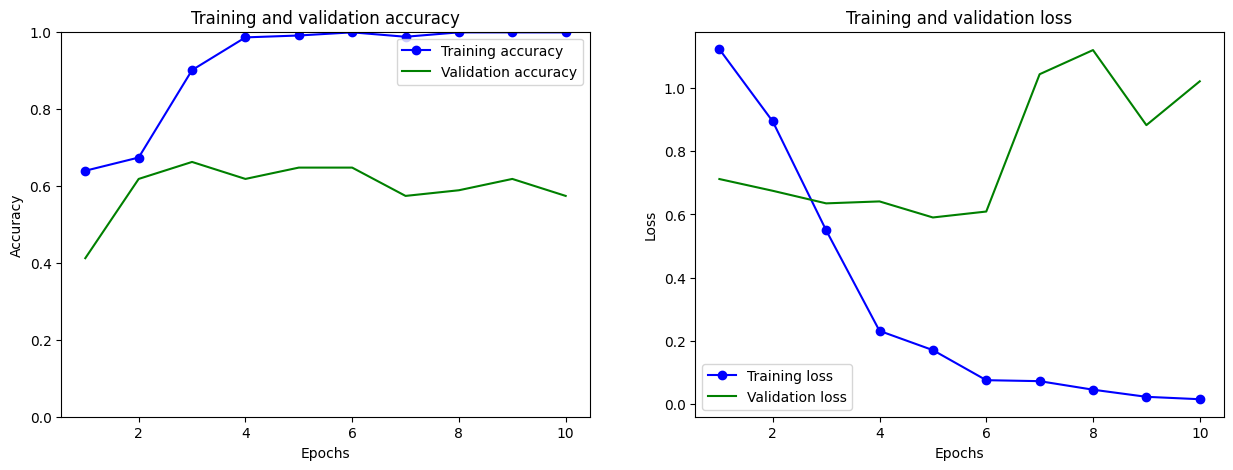

Test Loss:  0.79
Test Accuracy:  0.66


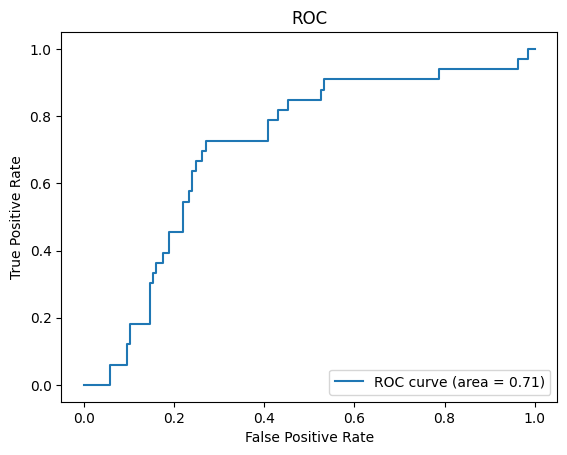

In [56]:
# Use simple neural network with training and test data and embedding layer
# output dimension size of 632
model, history, test_eval = rnn_model(vocab, 32, X_train_pad, y_train, X_test_pad, y_test)

The Simple RNN was able to achieve 99 % accuracy by the 8th epoch. However the validation accuracy was 57%. The training loss reached near 0 but was over 1 for the validation data set. The area under the ROC curve (AUC) was 0.71. The accuracy of the model on the test data was also 66.4%. This Simple RNN overfit on the training data leading to a decrease in accuracy and increase in loss in its performance on the validation and test data.

# LSTM Model
---
A Long Short-Term Memory (LSTM) model was built to improve on the RNN's performance because of its ability to capture longer range dependencies with its more complex structure. Its cells can be used to selectively remember or forget information which again is helpful for classifications that use sentences as input.

 The model was built with the following layers which werre similar to the RNN: embedding, bidirectional LSTM layer with 64 units, a dropout layer which sets 25% of the inputes to 0, and a dense layer which calculates the output using a Sigmoid activation function. The bidirectional layer was used to improve classification by not only using past information (earlier in a sentence) to inform future context, but to also use future information (further down in a sentence) to inform earlier context.

In [57]:
# Create a function that builds the model
def lstm_model(vocab, em_output_dim, Xtr, ytr, Xte,yte):
  # Create a simple RNN instance
  lstm_rnn = Sequential(name = "LSTM")

  #Add an embedding layer with inputs = vocab size + 1 and output dimension
  lstm_rnn.add(Embedding(\
                           input_dim = vocab+1,\
                           output_dim = em_output_dim))

  # Add another layer  with ReLu as the activation function
  lstm_rnn.add(Bidirectional(LSTM(64)))

  # Add a layer for dropping out layer for randomply setting inputs units to 0
  lstm_rnn.add(Dropout(0.25))

  # Add a dense layer that takes input, weights and bias, computes dot products
  # and pass results elemnt wise into the activation function
  lstm_rnn.add(\
                 Dense(1,
                 activation = 'sigmoid'))
  # Configure the model to use adam optimizer, binary cross entropy as the
  # loss function and accuracy as the model evaluation metric.
  lstm_rnn.compile(\
                     optimizer = 'adam',\
                     loss = 'binary_crossentropy',\
                     metrics = ['accuracy'])

  # Build the model by fitting it on training data. Set class weights to account
  # for inbalance in the data.
  history = lstm_rnn.fit(\
                           Xtr,\
                           np.array(ytr),\
                           validation_split = 0.1,\
                           epochs = 10,\
                           verbose = 1,\
                           class_weight = {0:1, 1:4.5})

  # Convert the test data to a numpy array
  yte = np.array(yte)

  # Evaluate the model performance on the test data
  test_eval = lstm_rnn.evaluate(Xte, yte)

 # Calculate and store model predictions for plotting the ROC curve.
  predictions = lstm_rnn.predict(Xte)

  # Print the model summary
  print(lstm_rnn.summary())

  # Plot the models training and validation loss and accuracy
  plot_history(hist = history)

  # Plot the models ROC curve
  plot_roc(yte, predictions)

  # Print the loss and accuracy values for the model in test mode.
  print("Test Loss: ", round(test_eval[0], 2))
  print("Test Accuracy: ", round(test_eval[1], 2))

  # Return the mode, its history and loss and accuracy values from
  # test mode.
  return lstm_rnn, history, test_eval

Epoch 1/10
20/20 [==============================] - 14s 459ms/step - loss: 1.1138 - accuracy: 0.3529 - val_loss: 0.6766 - val_accuracy: 0.7647
Epoch 2/10
20/20 [==============================] - 9s 472ms/step - loss: 1.0847 - accuracy: 0.8268 - val_loss: 0.5995 - val_accuracy: 0.7794
Epoch 3/10
20/20 [==============================] - 7s 357ms/step - loss: 0.9029 - accuracy: 0.9199 - val_loss: 0.5962 - val_accuracy: 0.8235
Epoch 4/10
20/20 [==============================] - 9s 464ms/step - loss: 0.6722 - accuracy: 0.9379 - val_loss: 0.4224 - val_accuracy: 0.7941
Epoch 5/10
20/20 [==============================] - 7s 357ms/step - loss: 0.3581 - accuracy: 0.9526 - val_loss: 0.4581 - val_accuracy: 0.7647
Epoch 6/10
20/20 [==============================] - 9s 453ms/step - loss: 0.1673 - accuracy: 0.9902 - val_loss: 0.3155 - val_accuracy: 0.8824
Epoch 7/10
20/20 [==============================] - 8s 416ms/step - loss: 0.0599 - accuracy: 0.9951 - val_loss: 0.3770 - val_accuracy: 0.8676
Epoch

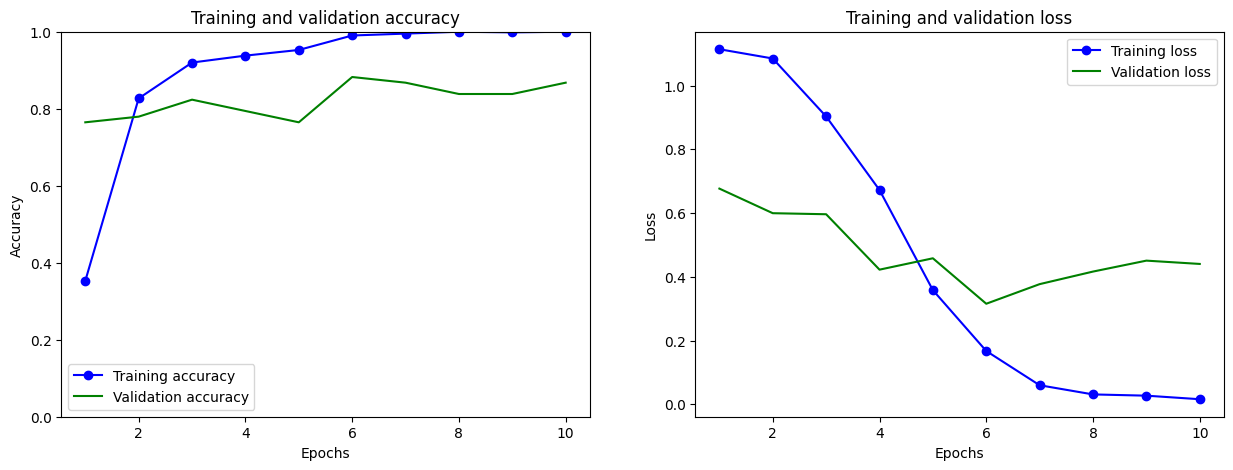

Test Loss:  0.53
Test Accuracy:  0.85


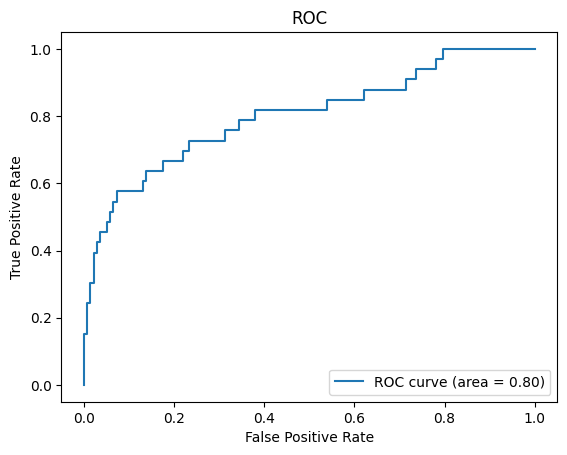

In [58]:
# Use a bidirectional lstm model with training and test data and embedding layer
# output dimension size of 32
model, history, test_eval = lstm_model(vocab, 32, X_train_pad, y_train, X_test_pad, y_test)

Similar to the Simple RNN, the model is over fitting. This is shown by how the training accuracy is better than the validation accuracy. However, the gap in accuracies between training and validation data is less than in the Simple RNN case. A similar trend was seen in the training and validation loss where an improvement was seen over the simple RNN. The test accuracy and loss, 85% and 0.53 also improved over over the RNN and well as the AUC (0.80).

# Transfer Learning Model
---
Finally, we attempt to use the concept of transfer learning to improve on the performance of the prior two models. We used a pre-trained Bidirectional Encoder Representations from Transformers (BERT) model from TensorFlow Hub and added layers used from previous models.

The following layers were used: input layer, BERT preprocessing layer, BERT encoder layer, dropout layer that sets 25% of inputs to 0, a dense layer for the Sigmoid activation function.

In [63]:
# Create a function for  building the transfer model based
# on https://www.tensorflow.org/text/tutorials/classify_text_with_bert
def transfer_model(Xtr, ytr, Xte,yte):
  # Save preprocessor and encoder urls
  tfhub_handle_preprocess =\
  'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

  tfhub_handle_encoder =\
   'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

  # Create the input layer to feed into Bert's preprocessing model, leave
  # shape empty to accomodate what the Bert model uses
  review_input = tensorflow.keras.layers.Input(shape= (),\
                                       dtype=tensorflow.string, name='review_input')

  # Create the preprocessing layer
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

  # Process the input through the processing later
  encoder_inputs = preprocessing_layer(review_input)

  # Create the encoder layer
  encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')

  # Create the BERT output by feeding  the preprocessing output into the encoder
  # layer
  outputs = encoder(encoder_inputs)

  # Create a layer that collects the pooled_output from BERT's final layer
  layer = outputs['pooled_output']

  # Add a dropout layer to prevent overfitting
  layer = tensorflow.keras.layers.Dropout(0.25, name = 'dropout')(layer)

  # Add a dense layer to computer the final classification output using sigmoid
  # as the activation function
  layer = tensorflow.keras.layers.Dense\
   (1, activation = 'sigmoid', name = 'classifier')(layer)

  # Construct the final model
  trans_model = tensorflow.keras.Model(review_input, outputs = layer)


  #Configure the model to use adam optimizer, binary cross entropy as the
  # loss function and accuracy as the model evaluation metric.
  trans_model.compile(\
                     optimizer = 'adam',\
                     loss = 'binary_crossentropy',\
                     metrics = ['accuracy'])

  # Build the model by fitting it on training data. Set class weights to account
  # for inbalance in the data.
  history = trans_model.fit(\
                           X_train,\
                           np.array(y_train),\
                           validation_split = 0.1,\
                           epochs = 10,\
                           verbose = 1,\
                           class_weight = {0:1, 1:4.5})

  # Convert the test data to a numpy array
  yte = np.array(yte)

  # Evaluate the model performance on the test data
  test_eval = trans_model.evaluate(Xte, yte)

 # Calculate and store model predictions for plotting the ROC curve.
  predictions = trans_model.predict(Xte)

  # Print the model summary
  print(trans_model.summary())

  # Plot the models training and validation loss and accuracy
  plot_history(hist = history)

  # Plot the models ROC curve
  plot_roc(yte, predictions)

  # Print the loss and accuracy values for the model in test mode.
  print("Test Loss: ", round(test_eval[0], 2))
  print("Test Accuracy: ", round(test_eval[1], 2))

Epoch 1/10
20/20 [==============================] - 72s 3s/step - loss: 1.1247 - accuracy: 0.5605 - val_loss: 0.5926 - val_accuracy: 0.7059
Epoch 2/10
20/20 [==============================] - 65s 3s/step - loss: 1.0409 - accuracy: 0.6618 - val_loss: 0.5565 - val_accuracy: 0.7059
Epoch 3/10
20/20 [==============================] - 66s 3s/step - loss: 0.9759 - accuracy: 0.6618 - val_loss: 0.5292 - val_accuracy: 0.7353
Epoch 4/10
20/20 [==============================] - 64s 3s/step - loss: 0.9297 - accuracy: 0.7320 - val_loss: 0.4981 - val_accuracy: 0.8088
Epoch 5/10
20/20 [==============================] - 61s 3s/step - loss: 0.8988 - accuracy: 0.7222 - val_loss: 0.4947 - val_accuracy: 0.7941
Epoch 6/10
20/20 [==============================] - 60s 3s/step - loss: 0.8799 - accuracy: 0.6928 - val_loss: 0.4495 - val_accuracy: 0.8235
Epoch 7/10
20/20 [==============================] - 64s 3s/step - loss: 0.8835 - accuracy: 0.7827 - val_loss: 0.4736 - val_accuracy: 0.8235
Epoch 8/10
20/20 [==

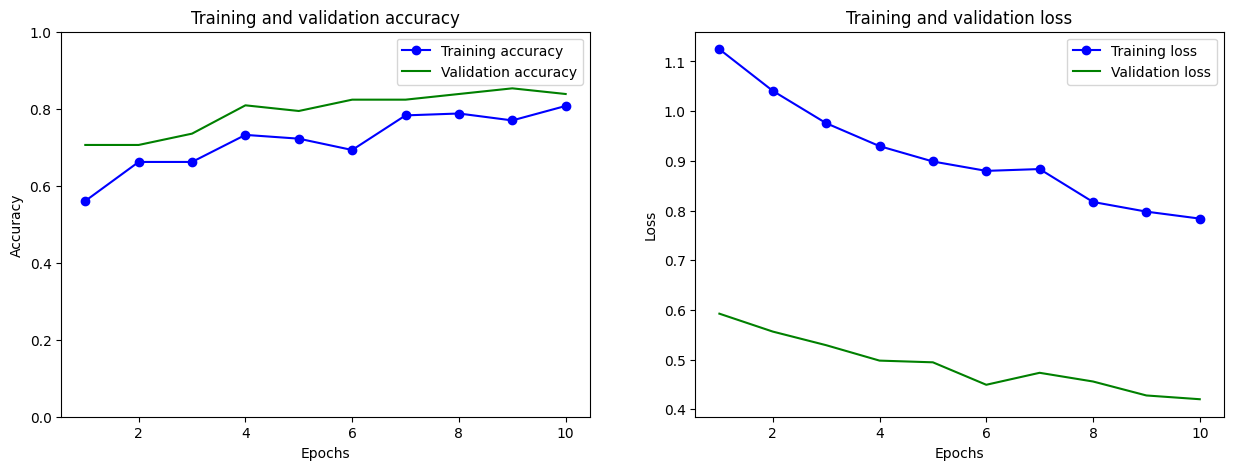

Test Loss:  0.43
Test Accuracy:  0.85


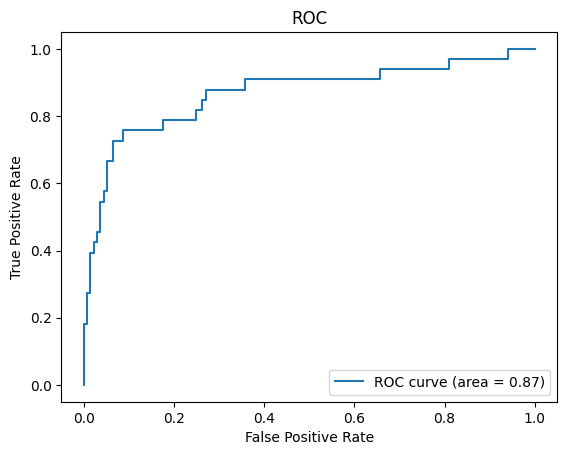

In [64]:
transfer_model(X_train, y_train, X_test, y_test)

In the BERT output, the validation dataset performed better than the training data in terms of accuracy and loss.

The behavior seen where the model performs better on the test set than the training set has been thought to be due to the dropout layer. During training the dropout layer sets 25% of input weights to 0 to avoid overfitting. However, during test, all weights are available which may lead to better performance since all features are now available for the prediction. This behavior was not observed in the RNN and LSTM model. This might be because these models' architectures were still not as good at understanding context as the transfer model.

The test accuracy (85%) and loss (0.43) were better than the training and validation accuracy and loss. It's performance was comparable to the LSTM model although the transfer model's AUC was 0.87 (better than LSTM). It's ability to improve performance in validation and test could be an indication that it is less likely to overfit than the Simple RNN and LSTM models.

The LSTM model was selected as the best model for future analysis because 1) it performed as well as transfer learning model in the test dataset and 2) it is a less complex and smaller model in size. It achieved above 80% accuracy which was the target accuracy for the project.

## Hyperparameter Tuning
Keras was used to perform hyperparameter tuning. The dropout rate and learning rate for the Adam optimizer were turned.

In [65]:
# Build hyperparameter tuning
def build_model(hp):
  # Create a simple RNN instance
  lstm_rnn = Sequential(name = "LSTM")

  #Add an embedding layer with inputs = vocab size + 1 and output dimension
  lstm_rnn.add(Embedding(\
                           input_dim = vocab+1,\
                           output_dim = 32))

  # Add another layer  with ReLu as the activation function
  lstm_rnn.add(Bidirectional(LSTM(64)))

  # Create dropout hyperparameters
  hp_dropout = hp.Choice('dropout', values = [0.05, 0.25, 0.50])

  # Create learning rate hyperparameters
  hp_learning_rate = hp.Float\
   ('learning_rate', min_value = 1e-4, max_value =1e-0, sampling = 'log')

  # Add a layer for dropping out layer for randomply setting inputs units to 0
  lstm_rnn.add(Dropout(hp_dropout))

  # Add a dense layer that takes input, weights and bias, computes dot products
  # and pass results elemnt wise into the activation function
  lstm_rnn.add(\
                 Dense(1,
                 activation = 'sigmoid'))
  # Configure the model to use adam optimizer, binary cross entropy as the
  # loss function and accuracy as the model evaluation metric.
  lstm_rnn.compile(\
                     optimizer=tensorflow.keras.optimizers.Adam(hp_learning_rate),\
                     loss = 'binary_crossentropy',\
                     metrics = ['accuracy'])
  return lstm_rnn

In [66]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(build_model,
                     objective = 'val_accuracy',
                     max_trials = 10,
                     directory = 'my_dir',
                     project_name = 'sentiment_analysis_bayesopt_1',
                                overwrite =True)

In [67]:
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [68]:
tuner.search(X_train_pad, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 01m 29s]
val_accuracy: 0.904411792755127

Best val_accuracy So Far: 0.904411792755127
Total elapsed time: 00h 13m 38s


In [69]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [70]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pad, np.array(y_train),\
                    epochs=10, validation_split=0.1,\
                    verbose = 1,\
                     class_weight = {0:1, 1:4.5})

Epoch 1/10
20/20 [==============================] - 14s 502ms/step - loss: 1.1126 - accuracy: 0.8268 - val_loss: 0.6691 - val_accuracy: 0.7647
Epoch 2/10
20/20 [==============================] - 8s 400ms/step - loss: 1.0163 - accuracy: 0.8627 - val_loss: 0.6337 - val_accuracy: 0.7353
Epoch 3/10
20/20 [==============================] - 8s 385ms/step - loss: 0.6635 - accuracy: 0.9183 - val_loss: 0.4644 - val_accuracy: 0.7647
Epoch 4/10
20/20 [==============================] - 9s 445ms/step - loss: 0.2689 - accuracy: 0.9624 - val_loss: 0.3669 - val_accuracy: 0.8676
Epoch 5/10
20/20 [==============================] - 7s 362ms/step - loss: 0.0724 - accuracy: 0.9951 - val_loss: 0.4061 - val_accuracy: 0.8529
Epoch 6/10
20/20 [==============================] - 9s 457ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.4043 - val_accuracy: 0.8676
Epoch 7/10
20/20 [==============================] - 10s 530ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.4712 - val_accuracy: 0.8235
Epoc

6/6 [==============================] - 1s 81ms/step
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          143232    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               49664     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 193025 (754.00 KB)
Trainable params: 193025 (754.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


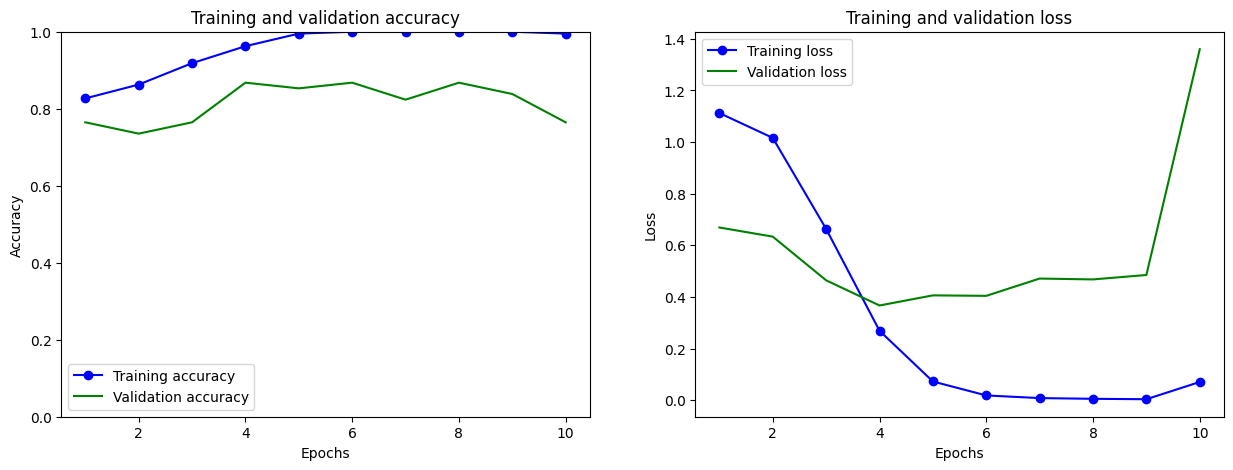

Test Loss:  1.1450622081756592
Test Accuracy:  0.8117647171020508


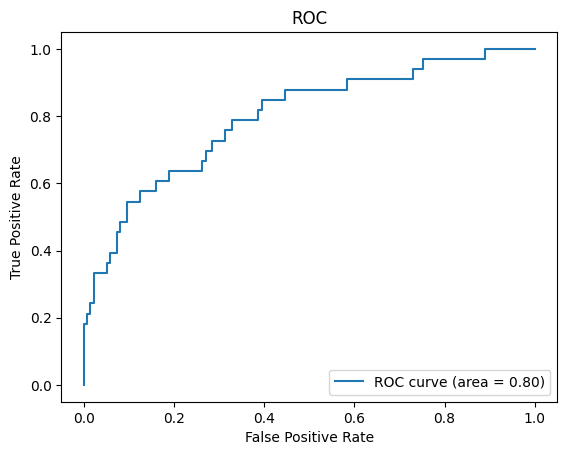

In [72]:
# Convert the test data to a numpy array
yte = np.array(y_test)

# Evaluate the model performance on the test data
test_eval = model.evaluate(X_test_pad, yte)

# Calculate and store model predictions for plotting the ROC curve.
predictions = model.predict(X_test_pad)

# Print the model summary
print(model.summary())

# Plot the models training and validation loss and accuracy
plot_history(hist = history)

# Convert predictions to binary labels based on a threshold (e.g., 0.5)
predictions_binary = np.where(predictions > 0.5, 1, 0)

# Plot the models ROC curve
plot_roc(yte, predictions)

# Print the loss and accuracy values for the model in test mode.
print("Test Loss: ", test_eval[0])
print("Test Accuracy: ", test_eval[1])

In [73]:
# Convert predictions to binary labels based on a threshold (e.g., 0.5)
predictions_binary = np.where(predictions > 0.5, 1, 0)

In [74]:
best_hps.values

{'dropout': 0.25, 'learning_rate': 0.001876787077703894}

The best hyperparameters were a dropout rate of 5% and a learning rate of 0.002.  This achieve an accuracy of 87% in the test set. However, there may be signs of overfitting with the training data achieving accuracies of 100% with the lower dropout rate again.

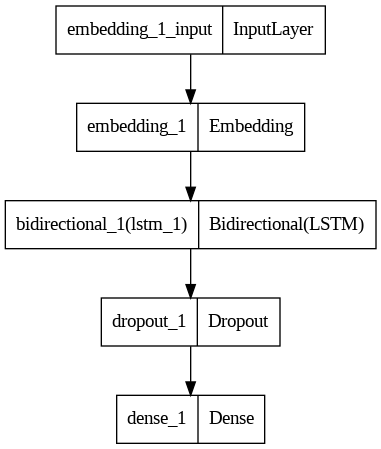

In [75]:
# Print final model architecture

tensorflow.keras.utils.plot_model(model)

In [76]:
# Classification Report
print(classification_report(y_test, predictions_binary, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.81      1.00      0.90       137
    Positive       1.00      0.03      0.06        33

    accuracy                           0.81       170
   macro avg       0.91      0.52      0.48       170
weighted avg       0.85      0.81      0.73       170



In [77]:
cm = confusion_matrix(y_test, predictions_binary)

In [78]:
cm

array([[137,   0],
       [ 32,   1]])

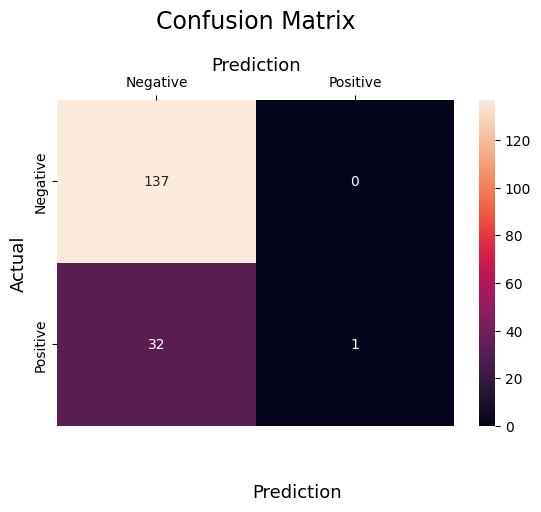

In [82]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

The confusion matrix shows that the rate of correct predictions for the negative class was 100% while the rate of correct predictions for the positive class was 3%. This difference in rates can be attributed to class inbalance and moving forward the transfer learning model may be used. The model could be used as is with it's performance on the negative class because for this context, it is more important to understand when there are negative sentiments.

## Conclusion
The LSTM model provided the least complex model with greater than 80% accuracy for predicting the sentiment of Starbucks reviews. A dropout rate of 25% and learning rate of 0.002 provided the best accuracy and loss. However, it seems the model was overfit and the class imbalance was not properly addressed by  to avoid overfitting. Future work should include investigate includsion of class weights during hyperparameter tuning.

Alternatively, BERT model provided improvement in classification from training to validation and could be used to address overfitting and imbalance.